In [1]:
from datetime import date
from glob import glob
import json
import math
import os
import pickle
import sys
import time

import gspread
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from scipy import integrate, interpolate, stats, ndimage

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp

In [4]:
%matplotlib notebook

#### Functions

In [5]:
def get_stim_event_inds(stim_table, stim_type, stim_param, sweep, trials='all'):
    if trials == 'resting':
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True) &
            (stim_table['resting_trial'] == True)
        ].index.values
    elif trials == 'running':
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True) &
            (stim_table['resting_trial'] == False)
        ].index.values
    else:
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True)
        ].index.values

In [6]:
def get_zFR(trig_FR, FRtime):
    
    trig_Z = np.zeros_like(trig_FR) * np.nan # try NaNs, it works
    baseline_avg = np.mean(trig_FR[FRtime < 0, :], axis=0)
    baseline_std = np.std(trig_FR[FRtime < 0, :], axis=0)
    nonzero_inds = np.nonzero(baseline_std)[0]
    trig_Z[:, nonzero_inds] = (trig_FR[:, nonzero_inds] - baseline_avg[None, nonzero_inds]) / baseline_std[None, nonzero_inds]
    
    return trig_Z

#### Load Zap_Zip-log_exp to get metadata for experiments

In [7]:
_gc = gspread.service_account() # need a key file to access the account
_sh = _gc.open('Templeton-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
metadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe

In [8]:
plotsdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\psilocybin_exp'

In [9]:
multisub_file = r"C:\Users\lesliec\OneDrive - Allen Institute\data\brain_states_subjects.csv"
subject_df = pd.read_csv(multisub_file, converters={'mouse': str}).astype({'analyze': bool})

### Load psilocybin and saline experiments

In [10]:
test_mouse = '669117'
test_days = ['psilocybin', 'saline']
inj_window = 30 * 60 # min to include as "post-injection" -> seconds
test_window = [-2.0, 0.0] # this will look at baseline
time_bin = 0.005 # size of time bins (s) for firing rate
resting_only = True

In [11]:
exp_data = {}
for expday in test_days:
    print('{} - {} day'.format(test_mouse, expday))
    exp_data[expday] = {}
    sub_meta = subject_df[(
        (subject_df['mouse'].str.contains(test_mouse)) & (subject_df['exp_type'].str.contains(expday))
    )].squeeze()
    ## Load EEGexp ##
    exp = EEGexp(sub_meta.data_loc, preprocess=False, make_stim_csv=False)
    exp_meta = metadata[(
        (metadata['mouse_name'].str.contains(test_mouse)) & (metadata['exp_name'].str.contains(sub_meta.experiment))
    )].squeeze()
    inj_times = [float(exp_meta['First injection time']), float(exp_meta['Second injection time'])]
    
    ## Load stim_log ##
    stim_log = pd.read_csv(exp.stimulus_log_file).astype({'parameter': str})

    ## Add injection time to stim_log ##
    stim_log['onset_from_inj2'] = stim_log['onset'] - inj_times[1]

    ## Add baseline speed to stim_log ##
    event_running_signal = np.load(os.path.join(exp.data_folder, 'evoked_data', 'event_running_speed.npy'))
    event_running_ts = np.load(os.path.join(exp.data_folder, 'evoked_data', 'event_running_times.npy'))
    evinds = np.nonzero((event_running_ts >= test_window[0]) & (event_running_ts < test_window[1]))[0]
    mean_speed = np.mean(event_running_signal[evinds, :], axis=0)
    stim_log['BLspeed'] = mean_speed
    stim_log['BL_resting_trial'] = stim_log['BLspeed'] < 0.1
    
    ## Load unit info ##
    fn_units_info = os.path.join(exp.data_folder, 'evoked_data', 'all_units_info.csv')
    if os.path.exists(fn_units_info):
        unit_info = pd.read_csv(fn_units_info)
        with open(os.path.join(exp.data_folder, 'evoked_data', 'units_event_spikes.pkl'), 'rb') as unit_file:
            all_unit_event_spikes = pickle.load(unit_file)
    else:
        print(' {} not found. Not analyzing this subject.\n'.format(fn_units_info))

    ## Make time bins for event spikes ##
    bins = np.arange(all_unit_event_spikes['event_window'][0], all_unit_event_spikes['event_window'][1] + time_bin, time_bin)
    timex = bins[:-1] + time_bin/2

    ## Get trials ##
    trial_log = stim_log[(stim_log['good'] == True) & (stim_log['BL_resting_trial'] == resting_only)]
    trialinds = trial_log.index.values
    xtimes = trial_log.onset_from_inj2.values
    print(' Getting baseline firing rates...')
    allBLFR = np.zeros((len(unit_info), len(stim_log)), dtype=float)
    allBLburst = np.zeros((len(unit_info), len(stim_log)), dtype=float)
    preBL = np.zeros((len(unit_info)), dtype=float)
    postBL = np.zeros((len(unit_info)), dtype=float)
    preburst = np.zeros((len(unit_info)), dtype=float)
    postburst = np.zeros((len(unit_info)), dtype=float)
    for uidx, unitrow in unit_info.iterrows():
        ## Get BLFR for all trials ##
        for ei, espikesi in enumerate(all_unit_event_spikes['event_spikes'][unitrow.unit_id]):
            spcounts, edges = np.histogram(espikesi, bins)
            allBLFR[uidx, ei] = np.mean(spcounts[timex < 0]) / time_bin
            ## Get burst rate for all trials ##
            burstcounts, edges = np.histogram(all_unit_event_spikes['event_bursts'][unitrow.unit_id]['times'][ei], bins)
            allBLburst[uidx, ei] = np.mean(burstcounts[timex < 0]) / time_bin
            
        ## Pre- and post- BLFR ###
        preBL[uidx] = np.mean(allBLFR[uidx, trialinds[np.nonzero(xtimes < 0)[0]]])
        postBL[uidx] = np.mean(allBLFR[uidx, trialinds[np.nonzero((xtimes > 0) & (xtimes < 30*60))[0]]])
        preburst[uidx] = np.mean(allBLburst[uidx, trialinds[np.nonzero(xtimes < 0)[0]]])
        postburst[uidx] = np.mean(allBLburst[uidx, trialinds[np.nonzero((xtimes > 0) & (xtimes < 30*60))[0]]])

    ## Add BLFR to unit_info ##
    unit_info['preBL'] = preBL
    unit_info['postBL'] = postBL
    unit_info['percent_change'] = ((postBL - preBL) / preBL) * 100
    unit_info['preburst'] = preburst
    unit_info['postburst'] = postburst
    unit_info['percent_burst_change'] = ((postburst - preburst) / preburst) * 100
    
    ## Store info ##
    exp_data[expday]['stim_log'] = stim_log
    exp_data[expday]['unit_info'] = unit_info
    exp_data[expday]['BLFR'] = allBLFR
    exp_data[expday]['BLburst'] = allBLburst
    exp_data[expday]['region_list'] = np.unique(unit_info.parent_region.values)

669117 - psilocybin day
Experiment type: electrical stimulation
 Getting baseline firing rates...


C:\Users\lesliec\Miniconda3\envs\tbd_eeg\lib\site-packages\ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\lesliec\Miniconda3\envs\tbd_eeg\lib\site-packages\ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in true_divide
C:\Users\lesliec\Miniconda3\envs\tbd_eeg\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\lesliec\Miniconda3\envs\tbd_eeg\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide


669117 - saline day
Experiment type: electrical stimulation
 Getting baseline firing rates...


Find common parent regions

In [12]:
common_regions = list(set(exp_data['psilocybin']['region_list']).intersection(exp_data['saline']['region_list']))
print(common_regions)

['SM-TH', 'RHP', 'PL', 'VIS', 'MO', 'HIP', 'RSP', 'other-TH', 'SS', 'ILA', 'ACA', 'RT-TH', 'OLF']


Plot baseline firing

<IPython.core.display.Javascript object>


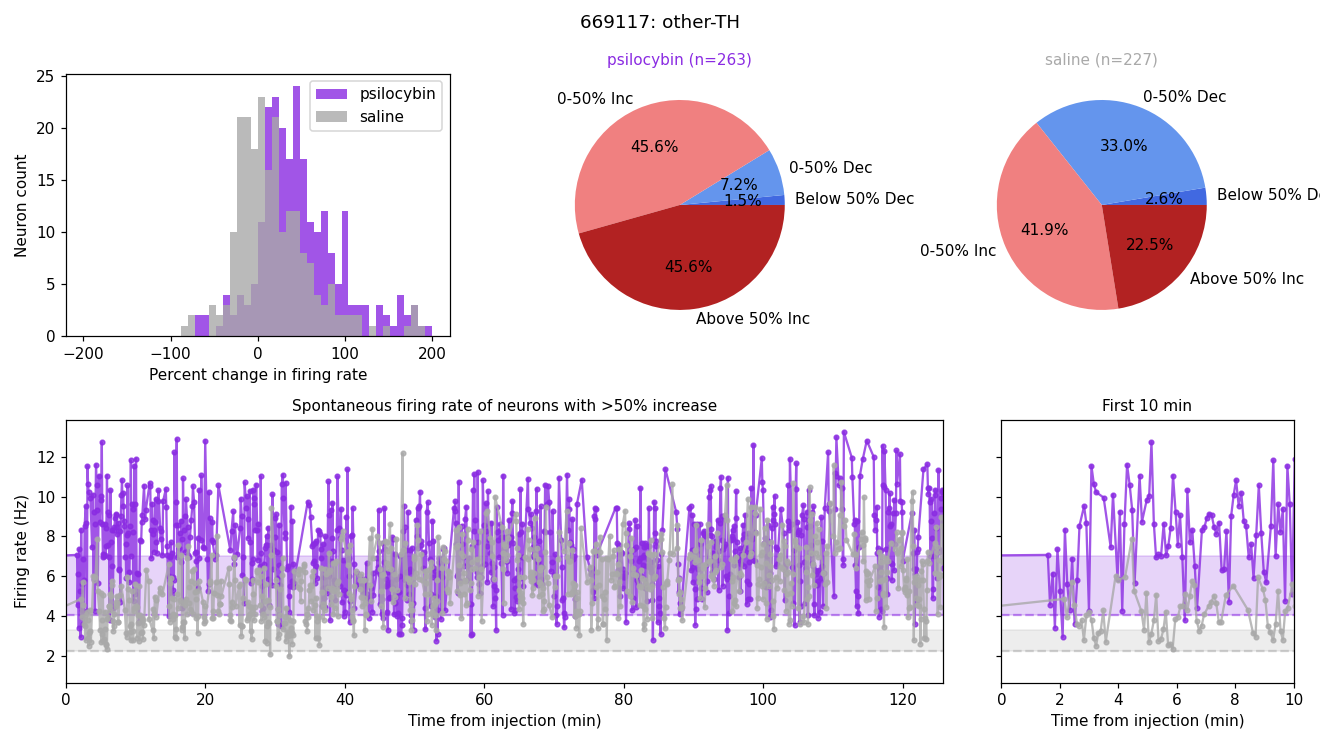

In [13]:
plot_region = 'other-TH'
comp_day = {'psilocybin': 'blueviolet', 'saline': 'darkgray'}

fig = plt.figure(figsize=(12, 6.75))
gs = fig.add_gridspec(ncols=1, nrows=2, left=0.05, right=0.98, top=0.9, bottom=0.08, hspace=0.32)
topaxs = gs[0].subgridspec(ncols=3, nrows=1, wspace=0.1).subplots()
botaxs = gs[1].subgridspec(ncols=2, nrows=1, width_ratios=[3,1], wspace=0.1).subplots(sharey=True)

for ii, (dayi, colori) in enumerate(comp_day.items()):
    region_unit_info = exp_data[dayi]['unit_info'][exp_data[dayi]['unit_info']['parent_region'] == plot_region]
    topaxs[0].hist(region_unit_info.percent_change, bins=50, range=(-200,200), facecolor=colori, alpha=0.8, label=dayi)
    
    pie_split = np.array([
        np.sum(region_unit_info.percent_change.values < -50),
        np.sum((region_unit_info.percent_change.values > -50) & (region_unit_info.percent_change.values < 0)),
        np.sum((region_unit_info.percent_change.values > 0) & (region_unit_info.percent_change.values < 50)),
        np.sum(region_unit_info.percent_change.values > 50)
    ]) / len(region_unit_info)
    topaxs[1+ii].pie(
        pie_split,
        labels=['Below 50% Dec', '0-50% Dec', '0-50% Inc', 'Above 50% Inc'],
        colors=['royalblue', 'cornflowerblue', 'lightcoral', 'firebrick'],
        autopct='%1.1f%%', normalize=False,
    )
    topaxs[1+ii].set_title('{} (n={:d})'.format(dayi, len(region_unit_info)), color=colori)
    
    ## Plot FR on bottom ##
    plot_uinds = region_unit_info[(region_unit_info['percent_change'] > 50)].index.values
    
    trial_log = exp_data[dayi]['stim_log'][
        (exp_data[dayi]['stim_log']['good'] == True) &
        (exp_data[dayi]['stim_log']['BL_resting_trial'] == resting_only)
    ]
    trialinds = trial_log.index.values
    xtimes = trial_log.onset_from_inj2.values

    popFR = np.mean(exp_data[dayi]['BLFR'][plot_uinds, :][:, trialinds], axis=0)
    botaxs[0].plot(xtimes / 60, popFR, color=colori, marker='.', alpha=0.8)
    botaxs[0].set(
        xlim=([0, xtimes[-1] / 60]),
        xlabel='Time from injection (min)',
        ylabel='Firing rate (Hz)',
        title='Spontaneous firing rate of neurons with >50% increase'
    )
    meanFR = np.mean(popFR[xtimes < 0])
    stdFR = np.std(popFR[xtimes < 0])
    botaxs[0].axhline(meanFR, color=colori, linestyle='dashed', alpha=0.5)
    botaxs[0].axhspan(meanFR, meanFR + 2*stdFR, color=colori, alpha=0.2)
    
    botaxs[1].plot(xtimes / 60, popFR, color=colori, marker='.', alpha=0.8)
    botaxs[1].set(
        xlim=([0, 10]),
        xlabel='Time from injection (min)',
        title='First 10 min'
    )
    botaxs[1].axhline(meanFR, color=colori, linestyle='dashed', alpha=0.5)
    botaxs[1].axhspan(meanFR, meanFR + 2*stdFR, color=colori, alpha=0.2)
    
topaxs[0].set(
    xlabel='Percent change in firing rate',
    ylabel='Neuron count',
)
topaxs[0].legend()
fig.suptitle('{}: {}'.format(test_mouse, plot_region))

## Save ##
figname = '{}_{}_PSI_saline_comp.png'.format(test_mouse, plot_region)
# fig.savefig(os.path.join(plotsdir, 'BLFR', figname), transparent=False, dpi=300)

Plot baseline bursting

<IPython.core.display.Javascript object>


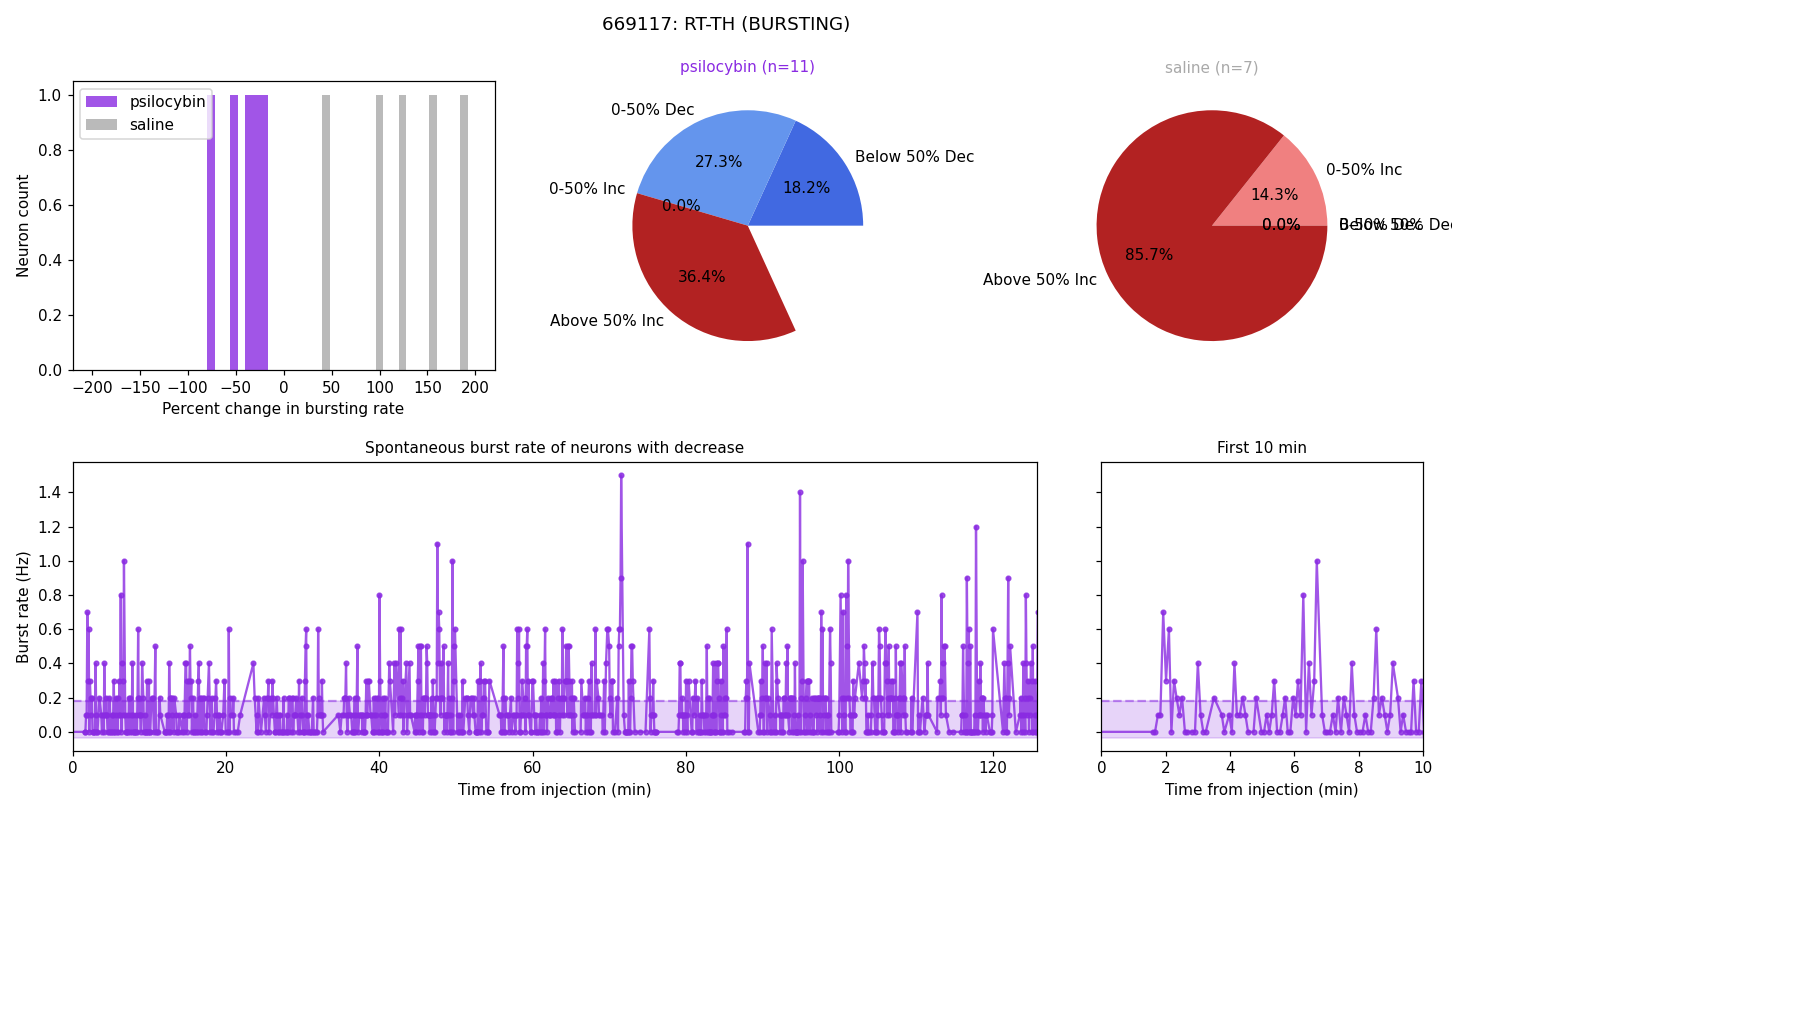

C:\Users\lesliec\Miniconda3\envs\tbd_eeg\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\lesliec\Miniconda3\envs\tbd_eeg\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [23]:
plot_region = 'RT-TH'
comp_day = {'psilocybin': 'blueviolet', 'saline': 'darkgray'}

fig = plt.figure(figsize=(12, 6.75))
gs = fig.add_gridspec(ncols=1, nrows=2, left=0.05, right=0.98, top=0.9, bottom=0.08, hspace=0.32)
topaxs = gs[0].subgridspec(ncols=3, nrows=1, wspace=0.1).subplots()
botaxs = gs[1].subgridspec(ncols=2, nrows=1, width_ratios=[3,1], wspace=0.1).subplots(sharey=True)

for ii, (dayi, colori) in enumerate(comp_day.items()):
    region_unit_info = exp_data[dayi]['unit_info'][exp_data[dayi]['unit_info']['parent_region'] == plot_region]
    topaxs[0].hist(region_unit_info.percent_burst_change, bins=50, range=(-200,200), facecolor=colori, alpha=0.8, label=dayi)
    
    pie_split = np.array([
        np.sum(region_unit_info.percent_burst_change.values < -50),
        np.sum((region_unit_info.percent_burst_change.values > -50) & (region_unit_info.percent_burst_change.values < 0)),
        np.sum((region_unit_info.percent_burst_change.values > 0) & (region_unit_info.percent_burst_change.values < 50)),
        np.sum(region_unit_info.percent_burst_change.values > 50)
    ]) / len(region_unit_info)
    topaxs[1+ii].pie(
        pie_split,
        labels=['Below 50% Dec', '0-50% Dec', '0-50% Inc', 'Above 50% Inc'],
        colors=['royalblue', 'cornflowerblue', 'lightcoral', 'firebrick'],
        autopct='%1.1f%%', normalize=False,
    )
    topaxs[1+ii].set_title('{} (n={:d})'.format(dayi, len(region_unit_info)), color=colori)
    
    ## Plot FR on bottom ##
    plot_uinds = region_unit_info[(region_unit_info['percent_burst_change'] < 0)].index.values
    
    trial_log = exp_data[dayi]['stim_log'][
        (exp_data[dayi]['stim_log']['good'] == True) &
        (exp_data[dayi]['stim_log']['BL_resting_trial'] == resting_only)
    ]
    trialinds = trial_log.index.values
    xtimes = trial_log.onset_from_inj2.values

    popFR = np.mean(exp_data[dayi]['BLburst'][plot_uinds, :][:, trialinds], axis=0)
    botaxs[0].plot(xtimes / 60, popFR, color=colori, marker='.', alpha=0.8)
    botaxs[0].set(
        xlim=([0, xtimes[-1] / 60]),
        xlabel='Time from injection (min)',
        ylabel='Burst rate (Hz)',
        title='Spontaneous burst rate of neurons with decrease'
    )
    meanFR = np.mean(popFR[xtimes < 0])
    stdFR = np.std(popFR[xtimes < 0])
    botaxs[0].axhline(meanFR, color=colori, linestyle='dashed', alpha=0.5)
    botaxs[0].axhspan(meanFR, meanFR - stdFR, color=colori, alpha=0.2)
    
    botaxs[1].plot(xtimes / 60, popFR, color=colori, marker='.', alpha=0.8)
    botaxs[1].set(
        xlim=([0, 10]),
        xlabel='Time from injection (min)',
        title='First 10 min'
    )
    botaxs[1].axhline(meanFR, color=colori, linestyle='dashed', alpha=0.5)
    botaxs[1].axhspan(meanFR, meanFR - stdFR, color=colori, alpha=0.2)
    
topaxs[0].set(
    xlabel='Percent change in bursting rate',
    ylabel='Neuron count',
)
topaxs[0].legend()
fig.suptitle('{}: {} (BURSTING)'.format(test_mouse, plot_region))

## Save ##
figname = '{}_{}_PSI_saline_BURSTcomp.png'.format(test_mouse, plot_region)
# fig.savefig(os.path.join(plotsdir, 'BLFR', figname), transparent=False, dpi=300)

In [ ]:
plot_day = 'psilocybin'

region_unit_info = exp_data[plot_day]['unit_info'][exp_data[plot_day]['unit_info']['parent_region'] == plot_region]
plot_uinds = region_unit_info[(region_unit_info['percent_change'] > 50)].index.values

trial_log = exp_data[plot_day]['stim_log'][
    (exp_data[plot_day]['stim_log']['good'] == True) &
    (exp_data[plot_day]['stim_log']['BL_resting_trial'] == resting_only)
]
trialinds = trial_log.index.values
xtimes = trial_log.onset_from_inj2.values
popFR = np.mean(exp_data[plot_day]['BLFR'][plot_uinds, :][:, trialinds], axis=0)
meanFR = np.mean(popFR[xtimes < 0])

fig, ax = plt.subplots(figsize=(8, 3), constrained_layout=True)
ax.plot(xtimes[xtimes > 0] / 60, ((popFR[xtimes > 0] - meanFR) / meanFR)*100, color='k', marker='.')#, linestyle='none')
ax.set(
    xlim=([0, xtimes[-1] / 60]),
    xlabel='Time from injection (min)',
    ylabel='Firing rate\n(% change from pre-injection)'
)
ax.axhspan(-50, 50, color='r', alpha=0.2)

In [ ]:
plot_day = 'saline'

region_unit_info = exp_data[plot_day]['unit_info'][exp_data[plot_day]['unit_info']['parent_region'] == plot_region]
plot_uinds = region_unit_info[(region_unit_info['percent_change'] > 50)].index.values

trial_log = exp_data[plot_day]['stim_log'][
    (exp_data[plot_day]['stim_log']['good'] == True) &
    (exp_data[plot_day]['stim_log']['BL_resting_trial'] == resting_only)
]
trialinds = trial_log.index.values
xtimes = trial_log.onset_from_inj2.values
popFR = np.mean(exp_data[plot_day]['BLFR'][plot_uinds, :][:, trialinds], axis=0)
meanFR = np.mean(popFR[xtimes < 0])

fig, ax = plt.subplots(figsize=(8, 3), constrained_layout=True)
ax.plot(xtimes[xtimes > 0] / 60, ((popFR[xtimes > 0] - meanFR) / meanFR)*100, color='k', marker='.')#, linestyle='none')
ax.set(
    xlim=([0, xtimes[-1] / 60]),
    xlabel='Time from injection (min)',
    ylabel='Firing rate\n(% change from pre-injection)'
)
ax.axhspan(-50, 50, color='r', alpha=0.2)

# For one subject - one experiment

In [10]:
recfolder = r'F:\psi_exp\mouse669117\pilot_aw_psi_2023-03-30_11-37-07\experiment1\recording1'
# exp = EEGexp(recfolder, preprocess=True, make_stim_csv=False)
exp = EEGexp(recfolder, preprocess=False, make_stim_csv=False)

exp_name = os.path.basename(os.path.dirname(exp.experiment_folder))

Experiment type: electrical stimulation


In [11]:
exp_meta = metadata[(
    (metadata['mouse_name'].str.contains(exp.mouse)) & (metadata['exp_name'].str.contains(exp_name))
)].squeeze()
inj_times = [float(exp_meta['First injection time']), float(exp_meta['Second injection time'])]
print(inj_times)

sub_meta = subject_df[(
    (subject_df['mouse'].str.contains(exp.mouse)) & (subject_df['experiment'].str.contains(exp_name))
)].squeeze()

[868.89, 1555.26]


## Look at trial-related baseline firing

In [12]:
test_window = [-2.0, 0.0] # this will look at baseline
time_bin = 0.0025 # size of time bins (s) for firing rate

In [13]:
stim_log = pd.read_csv(exp.stimulus_log_file).astype({'parameter': str})

## Add injection time to stim_log ##
stim_log['onset_from_inj2'] = stim_log['onset'] - inj_times[1]

## Add baseline speed to stim_log ##
event_running_signal = np.load(os.path.join(exp.data_folder, 'evoked_data', 'event_running_speed.npy'))
event_running_ts = np.load(os.path.join(exp.data_folder, 'evoked_data', 'event_running_times.npy'))
evinds = np.nonzero((event_running_ts >= test_window[0]) & (event_running_ts < test_window[1]))[0]
mean_speed = np.mean(event_running_signal[evinds, :], axis=0)
stim_log['BLspeed'] = mean_speed
stim_log['BL_resting_trial'] = stim_log['BLspeed'] < 0.1

## Get state label for each sweep ##
all_sweeps = np.unique(stim_log['sweep'].values)
sweep_state_list = []
for char in sub_meta.sweep_states.split(','):
    sweep_state_list.append(char)
if len(sweep_state_list) == 1:
    sweep_state_list = sweep_state_list * len(all_sweeps)
stim_log['state'] = stim_log.apply(lambda x: sweep_state_list[x.sweep], axis=1)

## Get depth label for each sweep ##
sweep_depth_list = []
for char in sub_meta.stim_depth.split(','):
    sweep_depth_list.append(char)
if len(sweep_depth_list) == 1:
    sweep_depth_list = sweep_depth_list * len(all_sweeps)
stim_log['stim_depth'] = stim_log.apply(lambda x: sweep_depth_list[x.sweep], axis=1)

## Get list of states and the middle current ##
states = np.unique(stim_log['state'].values)
currents = np.unique(stim_log[stim_log['stim_type'] == 'biphasic']['parameter'].values).astype(int)
if len(currents) > 1:
    ch_curr = str(currents[1])
else:
    ch_curr = str(currents[0])

In [14]:
## Load unit info ##
fn_units_info = os.path.join(exp.data_folder, 'evoked_data', 'all_units_info.csv')
if os.path.exists(fn_units_info):
    unit_info = pd.read_csv(fn_units_info)
    with open(os.path.join(exp.data_folder, 'evoked_data', 'units_event_spikes.pkl'), 'rb') as unit_file:
        all_unit_event_spikes = pickle.load(unit_file)
else:
    print(' {} not found. Not analyzing this subject.\n'.format(fn_units_info))

## Make time bins for event spikes ##
bins = np.arange(all_unit_event_spikes['event_window'][0], all_unit_event_spikes['event_window'][1] + time_bin, time_bin)
timex = bins[:-1] + time_bin/2

In [15]:
unit_info.head()

,unit_id,probe,peak_ch,depth,spike_duration,region,CCF_AP,CCF_DV,CCF_ML,parent_region
0,B0,probeB,0,3700,0.480737,VAL,269,174,187,SM-TH
1,B589,probeB,0,3700,0.480737,VAL,269,174,187,SM-TH
2,B1,probeB,0,3700,0.480737,VAL,269,174,187,SM-TH
3,B3,probeB,1,3700,0.480737,VAL,269,174,187,SM-TH
4,B5,probeB,1,3700,0.467002,VAL,269,174,187,SM-TH


In [16]:
print(np.unique(unit_info.parent_region.values))

['ACA' 'HIP' 'ILA' 'MO' 'OLF' 'PL' 'RHP' 'RSP' 'RT-TH' 'SM-TH' 'SS' 'VIS'
 'other-TH']


In [17]:
resting_only = True

## Get trials ##
trial_log = stim_log[(stim_log['good'] == True) & (stim_log['BL_resting_trial'] == resting_only)]
trialinds = trial_log.index.values
xtimes = trial_log.onset_from_inj2.values

allBLFR = np.zeros((len(unit_info), len(stim_log)), dtype=float)
preBL = np.zeros((len(unit_info)), dtype=float)
postBL = np.zeros((len(unit_info)), dtype=float)
for uidx, unitrow in unit_info.iterrows():
    ## Get BLFR for all trials ##
    for ei, espikesi in enumerate(all_unit_event_spikes['event_spikes'][unitrow.unit_id]):
#     for ei, espikesi in enumerate(all_unit_event_spikes['event_bursts'][unitrow.unit_id]['times']):
        spcounts, edges = np.histogram(espikesi, bins)
        allBLFR[uidx, ei] = np.mean(spcounts[timex < 0]) / time_bin
    
    ## Pre- and post- BLFR ###
    preBL[uidx] = np.mean(allBLFR[uidx, trialinds[np.nonzero(xtimes < 0)[0]]])
    postBL[uidx] = np.mean(allBLFR[uidx, trialinds[np.nonzero((xtimes > 0) & (xtimes < 30*60))[0]]])
    
## Add BLFR to unit_info ##
unit_info['preBL'] = preBL
unit_info['postBL'] = postBL
unit_info['percent_change'] = ((postBL - preBL) / preBL) * 100

C:\Users\lesliec\Miniconda3\envs\tbd_eeg\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\lesliec\Miniconda3\envs\tbd_eeg\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


In [18]:
unit_info.head()

,unit_id,probe,peak_ch,depth,spike_duration,region,CCF_AP,CCF_DV,CCF_ML,parent_region,preBL,postBL,percent_change
0,B0,probeB,0,3700,0.480737,VAL,269,174,187,SM-TH,0.088542,0.084388,-4.690990
1,B589,probeB,0,3700,0.480737,VAL,269,174,187,SM-TH,0.119792,0.078059,-34.837644
2,B1,probeB,0,3700,0.480737,VAL,269,174,187,SM-TH,0.010417,0.027426,163.291139
3,B3,probeB,1,3700,0.480737,VAL,269,174,187,SM-TH,0.244792,0.170886,-30.191220
4,B5,probeB,1,3700,0.467002,VAL,269,174,187,SM-TH,0.031250,0.006329,-79.746835


In [27]:
pregi = 'other-TH'
reg_units = unit_info[unit_info['parent_region'] == pregi]

In [28]:
lowlow = np.sum(reg_units.percent_change.values < -50) / len(reg_units)
low = np.sum((reg_units.percent_change.values > -50) & (reg_units.percent_change.values < 0)) / len(reg_units)
high = np.sum((reg_units.percent_change.values > 0) & (reg_units.percent_change.values < 50)) / len(reg_units)
highhigh = np.sum(reg_units.percent_change.values > 50) / len(reg_units)

<IPython.core.display.Javascript object>


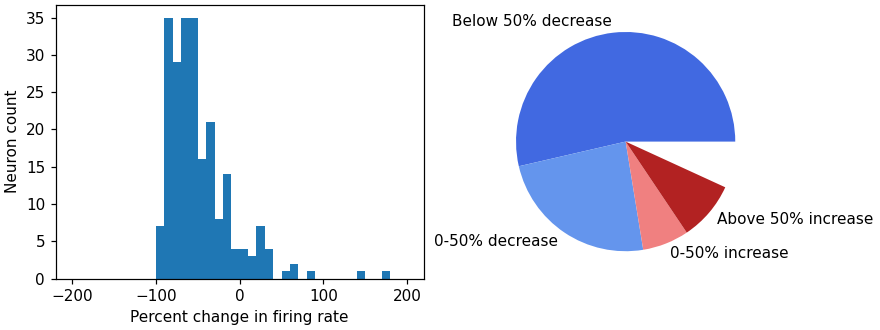

C:\Users\lesliec\Miniconda3\envs\tbd_eeg\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  if sys.path[0] == "":


In [29]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), constrained_layout=True)

axs[0].hist(reg_units.percent_change, bins=40, range=(-200,200)) #, density=True)
axs[0].set(
    xlabel='Percent change in firing rate',
    ylabel='Neuron count'
)

axs[1].pie(
    [lowlow, low, high, highhigh],
    labels=['Below 50% decrease', '0-50% decrease', '0-50% increase', 'Above 50% increase'],
    colors=['royalblue', 'cornflowerblue', 'lightcoral', 'firebrick']
);

Plot average FR of cells with above 50% increase

<IPython.core.display.Javascript object>


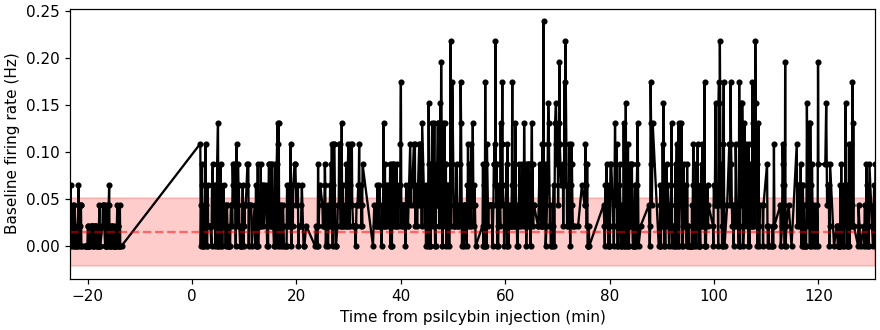

In [30]:
plot_uinds = reg_units[reg_units.percent_change > 50].index.values

fig, ax = plt.subplots(figsize=(8, 3), constrained_layout=True)
popFR = np.mean(allBLFR[plot_uinds, :][:, trialinds], axis=0)
ax.plot(xtimes / 60, popFR, color='k', marker='.')
ax.set(
    xlim=([xtimes[0] / 60, xtimes[-1] / 60]),
    xlabel='Time from psilcybin injection (min)',
    ylabel='Baseline firing rate (Hz)'
)
meanFR = np.mean(popFR[xtimes < 0])
stdFR = np.std(popFR[xtimes < 0])
ax.axhline(meanFR, color='r', linestyle='dashed', alpha=0.5)
ax.axhspan(meanFR - 2*stdFR, meanFR + 2*stdFR, color='r', alpha=0.2)

#### Test with single unit

In [33]:
chunit = unit_info.iloc[28]
print(chunit.unit_id)

BLFR = np.zeros((len(stim_log)), dtype=float)
for ei, espikesi in enumerate(all_unit_event_spikes['event_bursts'][chunit.unit_id]['times']):
    spcounts, edges = np.histogram(espikesi, bins)
    BLFR[ei] = np.mean(spcounts[timex < 0]) / time_bin
    
rest_log = stim_log[(stim_log['good'] == True) & (stim_log['BL_resting_trial'] == True)]
restinds = rest_log.index.values
xtimes = rest_log.onset_from_inj2.values

preinj_FR = np.mean(BLFR[np.nonzero(xtimes < 0)[0]])
postinj_FR = np.mean(BLFR[np.nonzero((xtimes > 0) & (xtimes < 30*60))[0]])
print('Percent change in BLFR = {:.2f}%'.format(((postinj_FR - preinj_FR) / preinj_FR) * 100))

B40
Percent change in BLFR = 125.68%


In [32]:
all_unit_event_spikes['event_bursts'][chunit.unit_id].keys()

dict_keys(['times', 'counts'])

In [34]:
stdpre = np.std(BLFR[np.nonzero(xtimes < 0)[0]])

<IPython.core.display.Javascript object>


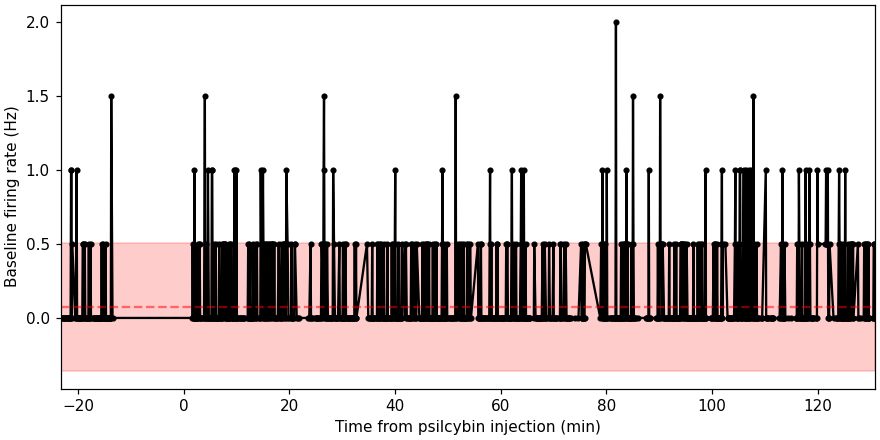

In [35]:
fig, ax = plt.subplots(figsize=(8,4), constrained_layout=True)

ax.plot(xtimes / 60, BLFR[restinds], color='k', marker='.')#, linestyle='none')
ax.set(
    xlim=([xtimes[0] / 60, xtimes[-1] / 60]),
    xlabel='Time from psilcybin injection (min)',
    ylabel='Baseline firing rate (Hz)'
)
ax.axhline(preinj_FR, color='r', linestyle='dashed', alpha=0.5)
ax.axhspan(preinj_FR - 2*stdpre, preinj_FR + 2*stdpre, color='r', alpha=0.2)

## To plot firing rate for entire recording
It is difficult to see any effect in these plots. Some way to subselect for units that are significantly affected?

In [28]:
running_file = os.path.join(exp.data_folder, 'running_signal.npy')
running_ts_file = os.path.join(exp.data_folder, 'running_timestamps_master_clock.npy')
if os.path.exists(running_file):
    run_signal = np.load(running_file)
    run_timestamps = np.load(running_ts_file)
else:
    print('Loading running from sync and saving...')
    run_signal, run_timestamps = exp.load_running()
    np.save(running_file, run_signal, allow_pickle=False)
    np.save(running_ts_file, run_timestamps, allow_pickle=False)

In [29]:
print(run_timestamps[0], run_timestamps[-1])

0.0 9640.28


#### Load unit info

In [30]:
## Load unit info ##
fn_units_info = os.path.join(exp.data_folder, 'evoked_data', 'all_units_info.csv')
if os.path.exists(fn_units_info):
    unit_info = pd.read_csv(fn_units_info)
    with open(os.path.join(exp.data_folder, 'evoked_data', 'units_allspikes.pkl'), 'rb') as unit_file:
        units_allspikes = pickle.load(unit_file)
else:
    print('{} not found. Not analyzing this subject.'.format(fn_units_stats))

unit_info.head()

,unit_id,probe,peak_ch,depth,spike_duration,region,CCF_AP,CCF_DV,CCF_ML,parent_region
0,B0,probeB,0,3700,0.480737,VAL,269,174,187,SM-TH
1,B589,probeB,0,3700,0.480737,VAL,269,174,187,SM-TH
2,B1,probeB,0,3700,0.480737,VAL,269,174,187,SM-TH
3,B3,probeB,1,3700,0.480737,VAL,269,174,187,SM-TH
4,B5,probeB,1,3700,0.467002,VAL,269,174,187,SM-TH


In [33]:
units_allspikes['B0']['bursts']

array([  33.61641079,  155.18538685,  155.36281952,  200.10849434,
        201.57135566,  203.30464931,  203.85784729,  224.90590359,
        242.41791132,  266.16863872,  271.99615826,  272.68038997,
        273.01412251,  276.44461439,  289.12711769,  296.44583106,
        339.55723097,  377.6969361 ,  392.47982472,  404.76015966,
        408.18045083,  412.74947236,  434.63517654,  463.31371786,
        468.01950165,  476.05027399,  495.56402736,  515.67084014,
        538.10106047,  547.66416877,  586.95366035,  592.88754055,
        611.5759864 ,  632.62186762,  635.51322578,  643.26013577,
        652.82410694,  664.45993875,  665.37330306,  692.45309976,
        693.43649722,  711.7293851 ,  728.68807376,  728.98300608,
        730.08213562,  759.76580253,  772.81880214,  793.8730497 ,
        806.40005471,  831.64092408,  889.3349678 ,  906.76265611,
        939.28290542,  953.12260863,  956.10520253, 1065.58525872,
       1068.51161781, 1115.69961908, 1150.98166336, 1152.98749

#### Get firing rate across whole recording for all units

In [35]:
## Make time bins for event spikes ##
time_bin = 0.1 # size of time bins (s) for firing rate
bins = np.arange(run_timestamps[0], run_timestamps[-1] + time_bin, time_bin)
timex = bins[:-1] + time_bin/2
gsigma = 50

In [36]:
allunits_FR = np.zeros((len(timex), len(unit_info)), dtype=float)
for idx, urow in unit_info.iterrows():
    spcounts, edges = np.histogram(units_allspikes[urow.unit_id]['bursts'], bins)
    allunits_FR[:, idx] = ndimage.gaussian_filter(spcounts, sigma=gsigma, output=float) / time_bin

In [37]:
BLinds = np.nonzero((timex > 60) & (timex < inj_times[0] - 300))[0]
meanBLFR = np.mean(allunits_FR[BLinds, :], axis=0)
stdBLFR = np.std(allunits_FR[BLinds, :], axis=0)

## Remove units with zero FR in BL period ##
zero_unit_inds = np.nonzero(stdBLFR == 0)[0]
unit_info.drop(zero_unit_inds, inplace=True)

## Get z-score ##
allunits_Z = (allunits_FR - meanBLFR) / stdBLFR

C:\Users\lesliec\Miniconda3\envs\tbd_eeg\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
C:\Users\lesliec\Miniconda3\envs\tbd_eeg\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


### Make some plots

<IPython.core.display.Javascript object>


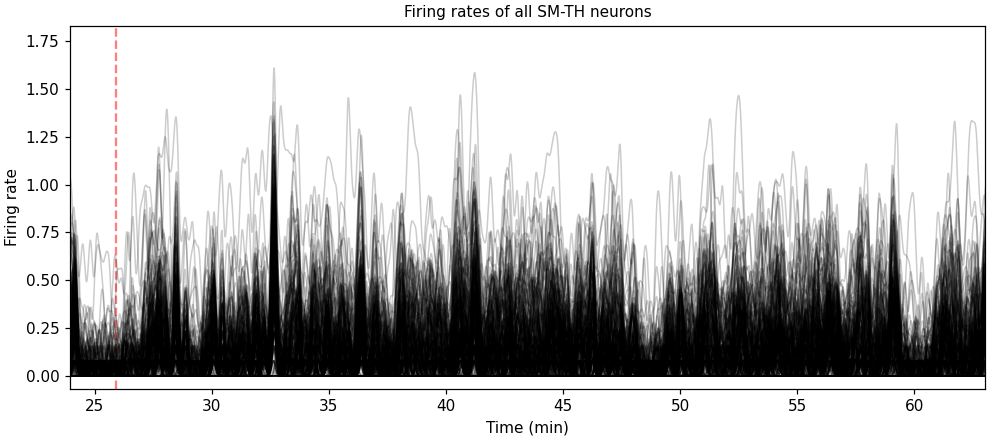

In [38]:
plot_region = 'SM-TH'
plot_inds = unit_info[unit_info['parent_region'] == plot_region].index.values

fig, ax = plt.subplots(figsize=(9, 4), constrained_layout=True)
for injtime in inj_times:
    ax.axvline(injtime / 60, color='r', linestyle='dashed', alpha=0.5)
    
ax.plot(timex / 60, allunits_FR[:, plot_inds], color='k', linewidth=1.0, alpha=0.2)
ax.set(
    xlim=[timex[0]/60, timex[-1]/60], xlabel='Time (min)', ylabel='Firing rate',
    title='Firing rates of all {} neurons'.format(plot_region)
);

#### Plot z-score relative to pre-injection time?

<IPython.core.display.Javascript object>


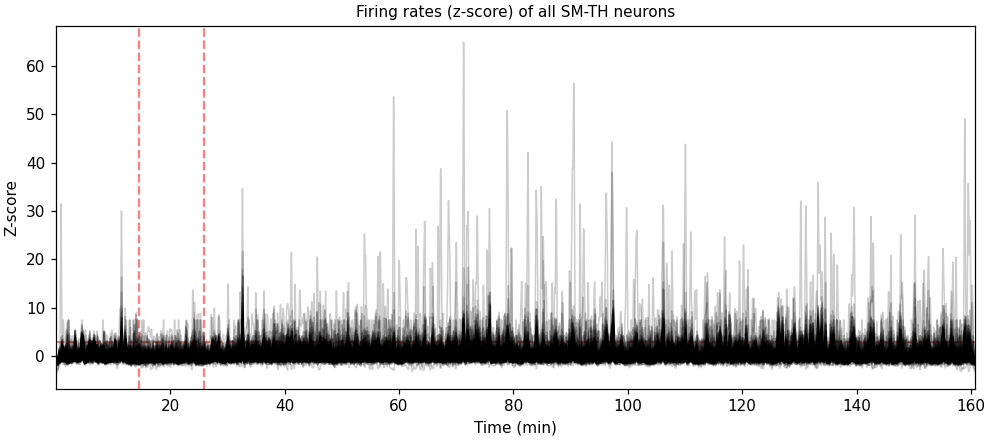

In [39]:
# plot_region = 'SM-TH'
# plot_inds = unit_info[unit_info['parent_region'] == plot_region].index.values

fig, ax = plt.subplots(figsize=(9, 4), constrained_layout=True)
for injtime in inj_times:
    ax.axvline(injtime / 60, color='r', linestyle='dashed', alpha=0.5)
ax.axhline(3, color='r', linestyle='dashed', alpha=0.5)
    
ax.plot(timex / 60, allunits_Z[:, plot_inds], color='k', linewidth=1.0, alpha=0.2)
ax.set(
    xlim=[timex[0]/60, timex[-1]/60], xlabel='Time (min)', ylabel='Z-score',
    title='Firing rates (z-score) of all {} neurons'.format(plot_region)
);

In [21]:
allunits_FR.shape

(96403, 1377)

In [22]:
len(unit_info)

1377

In [45]:
chunit = unit_info.iloc[849]
print(chunit.unit_id)
print(len(units_allspikes[chunit.unit_id]['spikes']))

D560
6994


In [46]:
spcounts, edges = np.histogram(units_allspikes[chunit.unit_id]['spikes'], bins)
smoothFR = ndimage.gaussian_filter(spcounts, sigma=gsigma, output=float) / time_bin

<IPython.core.display.Javascript object>


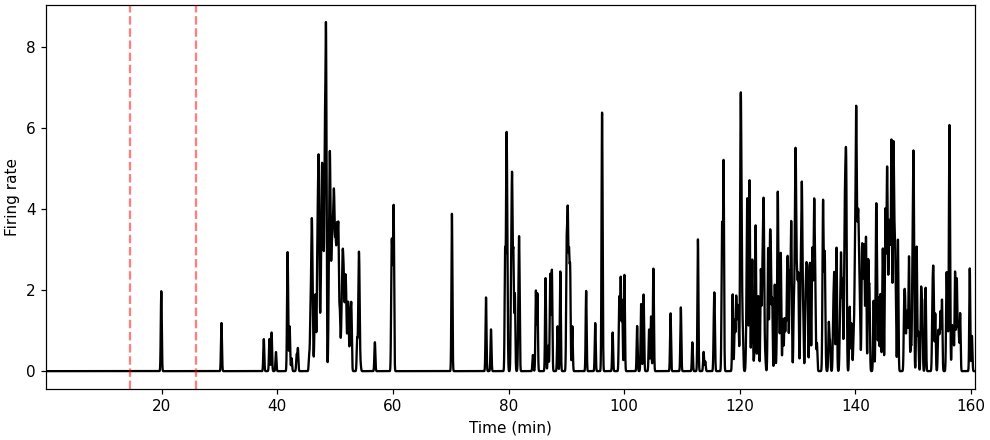

In [47]:
fig, ax = plt.subplots(figsize=(9, 4), constrained_layout=True)
ax.plot(timex / 60, smoothFR, color='k', linewidth=1.5)
for injtime in inj_times:
    ax.axvline(injtime / 60, color='r', linestyle='dashed', alpha=0.5)
ax.set(xlim=[timex[0]/60, timex[-1]/60], xlabel='Time (min)', ylabel='Firing rate');

## Testing metrics on single subjects with plots

In [11]:
call_saline_awake = False

skip_states = ['recovery']
psilocybin_window = 30 * 60 # min to include as "psilocybin" -> seconds; I tried 60 min on 5/10
substates = {'resting': True, 'running': False}
trial_threshold = 30 # must have more than this number of trials to be included in analysis
trial_max = 125 # limit some states that have many trials
unit_threshold = 25 # must have at least this number of units to be included in analysis, 5/10 was 5
time_bin = 0.0025 # size of time bins (s) for firing rate

test_window = [-2.0, 0.0] # this will look at baseline

In [23]:
subrow = subject_df.iloc[8]
print(subrow.mouse)

if not subrow.analyze:
    print('Skipping {} - {} for now, missing data.\n'.format(subrow.mouse, subrow.exp_type))

676726


Add state and stim depth info to stim_log and get stim current for analysis

In [24]:
## Load EEGexp and stim_log ##
exp = EEGexp(subrow.data_loc, preprocess=False, make_stim_csv=False)
stim_log = pd.read_csv(exp.stimulus_log_file).astype({'parameter': str})

## Add baseline speed to stim_log ##
event_running_file = os.path.join(exp.data_folder, 'evoked_data', 'event_running_speed.npy')
event_running_ts_file = os.path.join(exp.data_folder, 'evoked_data', 'event_running_times.npy')
event_running_signal = np.load(event_running_file)
event_running_ts = np.load(event_running_ts_file)
evinds = np.nonzero((event_running_ts >= test_window[0]) & (event_running_ts < test_window[1]))[0]
mean_speed = np.mean(event_running_signal[evinds, :], axis=0)
stim_log['BLspeed'] = mean_speed
stim_log['BL_resting_trial'] = stim_log['BLspeed'] < 0.1

### Get all states in experiment ###
all_sweeps = np.unique(stim_log['sweep'].values)

## Get state label for each sweep ##
sweep_state_list = []
for char in subrow.sweep_states.split(','):
    sweep_state_list.append(char)
if len(sweep_state_list) == 1:
    sweep_state_list = sweep_state_list * len(all_sweeps)
stim_log['state'] = stim_log.apply(lambda x: sweep_state_list[x.sweep], axis=1)
if call_saline_awake:
    stim_log['state'] = ['awake' if x == 'saline' else x for x in stim_log['state'].values]
## Get depth label for each sweep ##
sweep_depth_list = []
for char in subrow.stim_depth.split(','):
    sweep_depth_list.append(char)
if len(sweep_depth_list) == 1:
    sweep_depth_list = sweep_depth_list * len(all_sweeps)
stim_log['stim_depth'] = stim_log.apply(lambda x: sweep_depth_list[x.sweep], axis=1)
## Get list of states and the middle current ##
states = np.unique(stim_log['state'].values)
currents = np.unique(stim_log[stim_log['stim_type'] == 'biphasic']['parameter'].values).astype(int)
if len(currents) > 1:
    ch_curr = str(currents[1])
else:
    ch_curr = str(currents[0])

Experiment type: electrical and sensory stimulation


In [25]:
stim_log.head()

,stim_type,parameter,onset,offset,duration,sweep,good,mean_speed,resting_trial,BLspeed,BL_resting_trial,state,stim_depth
0,biphasic,40,187.18454,187.18494,0.0004,0,True,45.817398,False,45.517467,False,awake,deep
1,biphasic,40,193.79164,193.79204,0.0004,0,True,35.908266,False,38.926565,False,awake,deep
2,biphasic,40,201.25399,201.25439,0.0004,0,True,35.156539,False,35.820944,False,awake,deep
3,biphasic,40,207.75907,207.75947,0.0004,0,True,36.697959,False,35.300810,False,awake,deep
4,biphasic,40,215.03444,215.03484,0.0004,0,True,23.857850,False,35.046437,False,awake,deep


All-units info now includes parent region

In [26]:
## Load unit info ##
fn_units_info = os.path.join(exp.data_folder, 'evoked_data', 'all_units_info.csv')
if os.path.exists(fn_units_info):
    unit_info = pd.read_csv(fn_units_info)
    with open(os.path.join(exp.data_folder, 'evoked_data', 'units_event_spikes.pkl'), 'rb') as unit_file:
        all_unit_event_spikes = pickle.load(unit_file)
else:
    print('{} not found. Not analyzing this subject.'.format(fn_units_stats))
#     continue

## Make time bins for event spikes ##
bins = np.arange(all_unit_event_spikes['event_window'][0], all_unit_event_spikes['event_window'][1] + time_bin, time_bin)
timex = bins[:-1] + time_bin/2

unit_info.head()

,unit_id,probe,peak_ch,depth,spike_duration,region,CCF_AP,CCF_DV,CCF_ML,parent_region
0,B7,probeB,0,3660,0.521943,VAL,258,177,182,SM-TH
1,B2,probeB,1,3660,0.576884,VAL,258,177,182,SM-TH
2,B9,probeB,3,3640,0.521943,VAL,258,176,182,SM-TH
3,B11,probeB,4,3620,0.576884,VAL,258,175,182,SM-TH
4,B12,probeB,5,3620,0.673032,VAL,258,175,182,SM-TH


In [27]:
np.unique(unit_info['parent_region'].values)

array(['FRP', 'HIP', 'OLF', 'ORB', 'PAL', 'SM-TH', 'SS', 'STR', 'VIS',
       'other-TH'], dtype=object)

In [28]:
ROI_unit_info = {}
for region in np.unique(unit_info['parent_region'].values):
    udf = unit_info[unit_info['parent_region'] == region]
    if len(udf) >= unit_threshold:
        ROI_unit_info[region] = udf.sort_values(by='depth').reset_index(drop=True)
        print('{}: {:d} units'.format(region, len(udf)))

FRP: 61 units
HIP: 141 units
ORB: 315 units
PAL: 51 units
SM-TH: 64 units
SS: 254 units
STR: 136 units
VIS: 130 units
other-TH: 215 units


Get eventinds

In [29]:
state_event_inds = {}
for statei in states:
    if statei in skip_states:
        continue
    if statei in ['psilocybin', 'saline']:
        exp_meta = metadata[(
            (metadata['mouse_name'].str.contains(subrow.mouse)) &
            (metadata['exp_name'].str.contains(subrow.experiment))
        )].squeeze()
        stim_log['onset_from_inj2'] = stim_log['onset'] - float(exp_meta['Second injection time'])
        for substi, trialtest in substates.items():
            eventinds = stim_log[
                (stim_log['stim_type'] == 'biphasic') &
                (stim_log['parameter'] == ch_curr) &
                (stim_log['stim_depth'] == 'deep') &
                (stim_log['good'] == True) &
                (stim_log['BL_resting_trial'] == trialtest) &
                (stim_log['state'] == statei) &
                (stim_log['onset_from_inj2'] < psilocybin_window)
            ].index.values
            state_event_inds[statei + '_' + substi] = eventinds
    elif statei == 'awake':
        for substi, trialtest in substates.items():
            eventinds = stim_log[
                (stim_log['stim_type'] == 'biphasic') &
                (stim_log['parameter'] == ch_curr) &
                (stim_log['stim_depth'] == 'deep') &
                (stim_log['good'] == True) &
                (stim_log['BL_resting_trial'] == trialtest) &
                (stim_log['state'] == statei)
            ].index.values
            state_event_inds[statei + '_' + substi] = eventinds
    else:
        eventinds = stim_log[
            (stim_log['stim_type'] == 'biphasic') &
            (stim_log['parameter'] == ch_curr) &
            (stim_log['stim_depth'] == 'deep') &
            (stim_log['good'] == True) &
            (stim_log['BL_resting_trial'] == True) &
            (stim_log['state'] == statei)
        ].index.values
        state_event_inds[statei] = eventinds

In [30]:
print(len(state_event_inds['awake_resting']))
print(len(state_event_inds['psilocybin_resting']))

0
0


In [31]:
all_data = {
    'unit_metrics': {}, 'unit_zscores': {}, 'pop_fr': {}, 'trial_counts': {}, 'spike_latencies': {}
}
## Get metrics for each state/region #
for statei, event_inds in state_event_inds.items():
    if len(event_inds) < trial_threshold:
        print(' Only {:d} trials for {} state, not analyzing.'.format(len(event_inds), statei))
        continue
    elif len(event_inds) > trial_max:
        print(' {} has {:d} trials, downsampling trials to {:d}.'.format(statei, len(event_inds), trial_max))
        event_inds = np.random.choice(event_inds, size=trial_max, replace=False)
    all_data['trial_counts'][statei] = len(event_inds)
    all_data['unit_metrics'][statei] = {}
    all_data['unit_zscores'][statei] = {}
    all_data['pop_fr'][statei] = {}
    all_data['spike_latencies'][statei] = {}
    for regi, regdf in ROI_unit_info.items():
        unit_firing_rates = np.zeros((len(timex), len(regdf)), dtype=float) * np.nan
        sig_evoked_units = np.zeros(len(regdf), dtype=int)
        burst_trials = np.zeros(len(regdf), dtype=float)
        mean_burst_counts = np.zeros(len(regdf), dtype=float)
        early_spike_times = np.zeros((len(event_inds), len(regdf)), dtype=float) * np.nan
        late_spike_times = np.zeros((len(event_inds), len(regdf)), dtype=float) * np.nan

        ## Get unit event spike times ##
        reg_unit_metrics = []
        for ii, unitrow in regdf.iterrows():
            unit_event_spikes = [all_unit_event_spikes['event_spikes'][unitrow.unit_id][ei] for ei in event_inds]
            unit_event_bursts = [all_unit_event_spikes['event_bursts'][unitrow.unit_id]['times'][ei] for ei in event_inds]
            ## Get firing rates ##    
            unit_event_counts, edges = np.histogram(np.concatenate(unit_event_spikes), bins)
            unit_firing_rates[:, ii] = unit_event_counts / (time_bin * len(event_inds))

            prespikes = np.zeros(len(event_inds), dtype=int)
            postspikes = np.zeros(len(event_inds), dtype=int)
            trial_counts = np.zeros(len(event_inds), dtype=int)
            burst_counts = np.zeros(len(event_inds), dtype=int)
            for jj, uspikesi in enumerate(unit_event_spikes):
                ## Count spikes ##
                prespikes[jj] = np.sum((uspikesi >= -sig_test_window[1]) & (uspikesi <= -sig_test_window[0]))
                postspikes[jj] = np.sum((uspikesi >= sig_test_window[0]) & (uspikesi <= sig_test_window[1]))

                ## Count bursts ##
                windowbursts = np.nonzero(
                    (unit_event_bursts[jj] >= burst_window[0]) & (unit_event_bursts[jj] <= burst_window[1]))[0]
                if len(windowbursts) > 0:
                    trial_counts[jj] = 1
                burst_counts[jj] = len(np.nonzero(unit_event_bursts[jj] >= burst_window[0])[0])

                ## Find first spikes ##
                earlyspikes = np.nonzero((uspikesi >= early_window[0]) & (uspikesi <= early_window[1]))[0]
                if len(earlyspikes) > 0:
                    early_spike_times[jj, ii] = uspikesi[earlyspikes[0]]
                latespikes = np.nonzero((uspikesi >= late_window[0]) & (uspikesi <= late_window[1]))[0]
                if len(latespikes) > 0:
                    late_spike_times[jj, ii] = uspikesi[latespikes[0]]

            wstat, pval = stats.wilcoxon(x=postspikes, y=prespikes, zero_method='zsplit')
            spcount = np.mean(postspikes) - np.mean(prespikes)

            reg_unit_metrics.append([
                unitrow.unit_id, pval, spcount, np.nanmedian(early_spike_times[:,ii]), np.nanmedian(late_spike_times[:,ii]),
                np.mean(trial_counts), np.mean(burst_counts), np.mean(unit_firing_rates[timex < 0, ii])
            ])
            sig_evoked_units[ii] = pval < sigalpha
            burst_trials[ii] = np.mean(trial_counts) # fraction of trials with burst
            mean_burst_counts[ii] = np.mean(burst_counts) # avg number of evoked bursts
        unit_metrics_df = regdf.merge(
            pd.DataFrame(reg_unit_metrics, columns=[
                'unit_id', 'p_value', 'mean_spike_diff', 'early_latency', 'late_latency',
                'burst_prob', 'burst_count', 'baselineFR'
            ]), on='unit_id', how='left')
        all_data['unit_metrics'][statei][regi] = unit_metrics_df
        all_data['unit_zscores'][statei][regi] = [timex, get_zFR(unit_firing_rates, timex)]
        all_data['pop_fr'][statei][regi] = [timex, np.mean(unit_firing_rates, axis=1)]
        all_data['spike_latencies'][statei][regi] = [early_spike_times, late_spike_times]

#         all_subjects_states_info.append([
#             subrow.mouse, subrow.exp_type, statei, len(event_inds), regi, len(regdf),
#             np.mean(unit_firing_rates[timex < 0, :]), np.mean(sig_evoked_units), np.median(burst_trials),
#             np.mean(mean_burst_counts), np.nanmedian(early_spike_latency), np.nanmedian(late_spike_latency)
#         ])

 Only 0 trials for awake_resting state, not analyzing.


NameError: name 'sig_test_window' is not defined

### Plotting firing rate scatter for 2 states

In [20]:
for regi, df in ROI_unit_info.items():
    print('{}: {:d} units'.format(regi, len(df)))

ACA: 19 units
ILA: 15 units
MO: 99 units
PL: 205 units
SM-TH: 82 units
SS: 120 units
other-TH: 53 units


In [35]:
compare_states = ['awake_running', 'saline_running']
# plot_areas = ['MO', 'PL', 'ILA', 'ACA', 'RSP', 'SS', 'VIS', 'OLF', 'SM-TH', 'RT-TH', 'other-TH', 'HIP'] # 669117
# plot_areas = ['MO', 'PL', 'ORB', 'FRP', 'SS', 'OLF', 'SM-TH', 'other-TH', 'HIP'] # 669118
plot_areas = ['MO', 'ORB', 'FRP', 'STR', 'SS', 'VIS', 'OLF', 'HIP', 'SM-TH', 'RT-TH', 'other-TH'] # 666196
acolors = plt.cm.hsv(np.linspace(0, 1, len(plot_areas)))

Scatter plot of baseline firing rates in "compare_states"

<IPython.core.display.Javascript object>


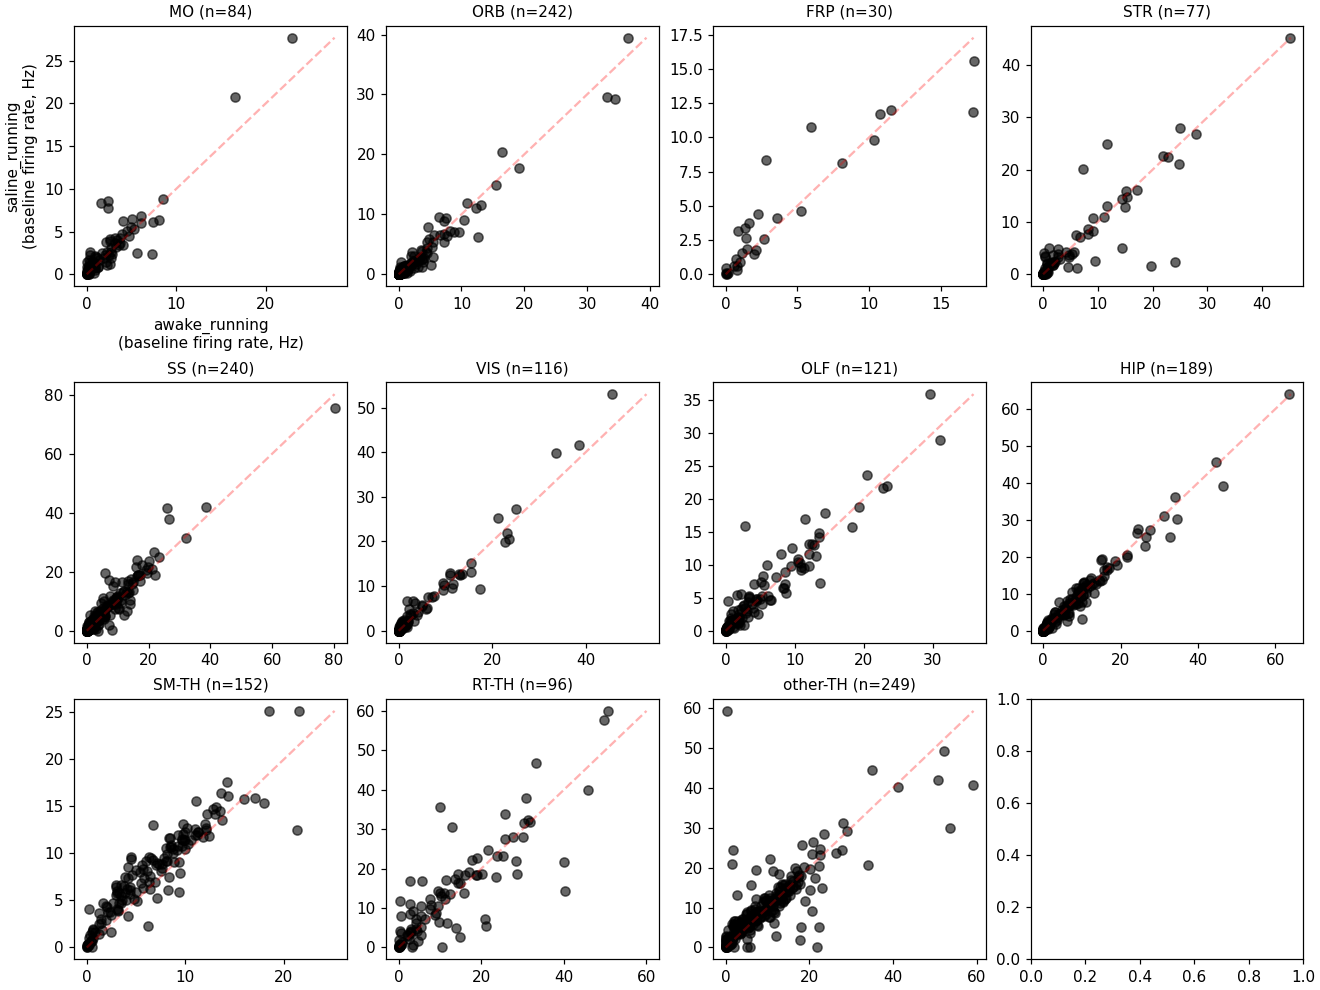

In [36]:
fig, axs = plt.subplots(3, 4, figsize=(12,9), constrained_layout=True)

for ax, regi in zip(axs.flatten(), plot_areas):
    scatter_vals = []
    for statei in compare_states:
        scatter_vals.append(all_data['unit_metrics'][statei][regi]['baselineFR'].values)
    min_val = np.min(scatter_vals)
    max_val = np.max(scatter_vals)
    ax.plot([min_val, max_val], [min_val, max_val], color='r', linestyle='dashed', alpha=0.3)
    ax.scatter(scatter_vals[0], scatter_vals[1], color='k', alpha=0.6)
    ax.set_title('{} (n={:d})'.format(regi, len(scatter_vals[0])))

axs[0,0].set_xlabel('{}\n(baseline firing rate, Hz)'.format(compare_states[0]))
axs[0,0].set_ylabel('{}\n(baseline firing rate, Hz)'.format(compare_states[1]))

## Save ##
figname = '{}_{}_baselineFR_allregions.png'.format(subrow.mouse, subrow.exp_type)
fig.savefig(os.path.join(plotsdir, 'ind_sub_evoked_units', figname), transparent=False, dpi=300)